In [1]:
#@title Run this code to install the package. 
# installing a package for reading .abf files
%pip install --upgrade pyabf

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for pyabf: filename=pyabf-2.2.8-cp36-none-any.whl size=47650 sha256=6556017dcd285923785f04fc550dde7b10ab20eb6bbf555a23ed3aa3d59bb135
  Stored in directory: /root/.cache/pip/wheels/d6/f5/00/be17ca092e5e11c1a65af2424ebb3bf7040ab3bfb49e6e17f7
Successfully built pyabf


In [2]:
from scipy.optimize import curve_fit
import numpy as np
import pyabf
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import pandas as pd

In [3]:
t1= []
t2=[]
t1 = [int(1.0665*20000)]
t2 = [int(1.0695*20000)]
offset1 = int(0.01005*20000)
offset2 = int(0.20025*20000)
for i in range(4):
      t1.append(t1[-1]+offset1)
      t2.append(t2[-1]+offset1) 
for i in range(4):
  for j in range(5):
    t1.append(t1[-5]+offset2)
    t2.append(t2[-5]+offset2)
print(t1)
print(t2)

[21330, 21531, 21732, 21933, 22134, 25335, 25536, 25737, 25938, 26139, 29340, 29541, 29742, 29943, 30144, 33345, 33546, 33747, 33948, 34149, 37350, 37551, 37752, 37953, 38154]
[21389, 21590, 21791, 21992, 22193, 25394, 25595, 25796, 25997, 26198, 29399, 29600, 29801, 30002, 30203, 33404, 33605, 33806, 34007, 34208, 37409, 37610, 37811, 38012, 38213]


In [4]:
#@title
#@title import matplotlib and set defaults
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()
init_notebook_mode(connected=False)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

Output hidden; open in https://colab.research.google.com to view.

In [5]:
#@title
def artifcat_removal(x_in, start, end):
  x_out = x_in.copy()
  from scipy.interpolate import interp1d
  xq = np.arange(start,end)
  f =  interp1d(np.array([start,end]),x_in[[start, end]],kind='linear')
  x_out[xq] = x_out[xq] - f(xq)
  return x_out

def manual_manip_cathodal(signal_in, g):
  f = 20000
  x_in = signal_in.copy()
  if g == 'a':
    end_1 = f*1.22
    start_2 = f*1.22
  elif g == 'b':
    end_1 = f*1.42
    start_2 = f*1.42    
  elif g == 'c':
    end_1 = f*1.62
    start_2 = f*1.62
  elif g == 'd':
    end_1 = f*1.82
    start_2 = f*1.82
  elif g == 'e':
    end_1 = f*1.99
    start_2 = f*1.99
  start_1 = f*1.02
  end_2 = f*1.99
  
  signal_ = artifcat_removal(x_in, int(start_1), int(end_1))  
  signal_out = artifcat_removal(signal_, int(start_2), int(end_2))
  return signal_out

def manual_manip_anodal(signal_in):
  f = 20000
  x_in = signal_in.copy()
  start = int(f*1.02)
  end = int(f*1.99)
  signal_out = artifcat_removal(x_in, start, end)
  return signal_out

from scipy.optimize import curve_fit
# define the true objective function
def objective(x, a, b):
    return a * x + b

def EPSP_calc(t1,t2,time,signal):   
  popt, _ = curve_fit(objective, time[t1:t2], signal[t1:t2])
  print(popt[0])
  return  popt[0]

In [ ]:
len(t2)

25

In [ ]:
#Now, let's link to your GoogleDrive. Run this cell and follow the authorization instructions:
#(We recommend putting a copy of the github repo in your google drive if you are using the demo "examples")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setup your project variables:
# PLEASE EDIT THESE:
  
ProjectFolderName = 'Pathway Interaction Project'

#don't edit these:
data_path = '/content/drive/My Drive/Pathway Interaction Project/Raw Data/' #Enter the list of videos or folder to analyze.
#!ls "/content/drive/My Drive/Pathway Interaction Project/Raw Data/"

In [ ]:
# getting list of 
data_files = glob.glob("/content/drive/My Drive/Pathway Interaction Project/Raw Data/*.abf")

In [ ]:
data_files

In [ ]:
abf = pyabf.ABF(data_files[-32])
df = pd.DataFrame({
    'time': abf.sweepX, 
    'voltage': abf.sweepY
}
)

In [ ]:
configure_plotly_browser_state()

idx = []
EPSP_slope = {'control': [], 'anodal': [], 'cathodal': []}

for sweepNumber in abf.sweepList[0:2]:   
    abf.setSweep(sweepNumber)
    df.iplot(kind='line',x='time',y='voltage', color=['white'], 
theme='solar', mode='lines',title='membrane potential')
print(abf.sweepList[-1])

In [ ]:
print(abf.headerText) # display header information in the console
abf.headerLaunch() # display header information in a web browser

In [ ]:
address_book = pd.read_excel('/content/drive/My Drive/Pathway Interaction Project/data_list.xlsx')
path_keys ={'TBS-SC','TBS-EC'}
address =  {}
for path_key in path_keys:
  address[path_key] = address_book[path_key]
 

In [ ]:
g_cath = address_book['g_cath']  
abf = pyabf.ABF(address['TBS-EC'][2])
df = pd.DataFrame({
    'time': abf.sweepX,    
}
)
df_new = pd.DataFrame({
    'time': abf.sweepX,    
}
)
sweeps = []
for sweepNumber in abf.sweepList:
    abf.setSweep(sweepNumber)
    df['sweep_'+str(sweepNumber)] = abf.sweepY
    sweeps.append('sweep_'+str(sweepNumber))
address['TBS-EC'][2]
# group = g_cath.iloc[2]
group = g_cath.to_numpy()

In [ ]:
len(address['TBS-EC'])

19

In [ ]:
g_cath = address_book['g_cath']  
temp = {'stim':[], 'address':[]}
for nPulse in range(len(t1)):
  temp.update({'nPulse_'+str(nPulse+1):[]}) 
for nExp in range(len(address['TBS-EC'])):
  abf = pyabf.ABF(address['TBS-EC'][nExp])
  for sweepNumber in abf.sweepList:
    if sweepNumber%2==0: 
      stim_group = 'control'
      signal = abf.sweepY
    elif sweepNumber%4==1:
       stim_group = 'anodal'
       signal = manual_manip_anodal(abf.sweepY)
    elif sweepNumber%4==3:
      stim_group = 'cathodal' 
      signal = manual_manip_cathodal(abf.sweepY, g = g_cath[nExp])
    temp['stim'].append(stim_group)
    temp['address'].append(address['TBS-EC'][nExp])
    for nPulse in range(len(t1)):

      temp['nPulse_'+str(nPulse+1)].append(EPSP_calc(t1[nPulse],t2[nPulse],time=abf.sweepY,signal = signal))
data_=pd.DataFrame.from_dict(temp)

0.9999999999999624
0.999999999999963
0.9999999999999588
0.9999999999999645
0.9999999999999599
0.9999999999999659
0.9999999999999646
0.9999999999999619
0.999999999999963
0.9999999999999645
0.9999999999999655
0.9999999999999635
0.9999999999999635
0.9999999999999611
0.9999999999999629
0.9999999999999648
0.9999999999999635
0.9999999999999621
0.9999999999999596
0.999999999999962
0.9999999999999655
0.9999999999999636
0.9999999999999628
0.9999999999999611
0.9999999999999584
1.0143092380586538
1.0079962195725929
1.0222649308835563
1.0253645188238232
1.036995242103949
1.0054732814650564
1.008265415026618
1.0153782885667515
1.0270723348200979
1.0247380610739185
1.0074687418306927
1.008919155552629
1.0160192288826375
1.0390455406214796
1.013644658580272
1.004931751059611
1.0100448987048276
1.028573537928056
1.03651304214088
0.972417027602476
1.01040605646442
1.0071129843437563
1.0130597016508582
0.9554265992175062
0.9568093919834958
0.9999999999999624
0.999999999999963
0.9999999999999588
0.999999

In [ ]:
data_

,stim,address,nPulse_1,nPulse_2,nPulse_3,nPulse_4,nPulse_5,nPulse_6,nPulse_7,nPulse_8,nPulse_9,nPulse_10,nPulse_11,nPulse_12,nPulse_13,nPulse_14,nPulse_15,nPulse_16,nPulse_17,nPulse_18,nPulse_19,nPulse_20,nPulse_21,nPulse_22,nPulse_23,nPulse_24,nPulse_25
0,control,/content/drive/My Drive/Pathway Interaction Pr...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,anodal,/content/drive/My Drive/Pathway Interaction Pr...,1.014309,1.007996,1.022265,1.025365,1.036995,1.005473,1.008265,1.015378,1.027072,1.024738,1.007469,1.008919,1.016019,1.039046,1.013645,1.004932,1.010045,1.028574,1.036513,0.972417,1.010406,1.007113,1.013060,0.955427,0.956809
2,control,/content/drive/My Drive/Pathway Interaction Pr...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,cathodal,/content/drive/My Drive/Pathway Interaction Pr...,1.028175,1.015745,1.043840,1.049943,1.072844,1.010777,1.016275,1.030280,1.053306,1.048710,1.014706,1.017562,1.031542,1.076882,1.026867,0.997182,0.994261,0.983674,0.979138,1.015761,0.994054,0.995936,0.992538,1.025468,1.024678
4,control,/content/drive/My Drive/Pathway Interaction Pr...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,cathodal,/content/drive/My Drive/Pathway Interaction Pr...,1.006259,1.006798,1.010407,1.001808,1.020748,1.003858,1.018871,1.006910,1.015300,0.998903,1.004658,1.007017,1.008551,1.025075,1.030003,1.004922,1.010562,1.006278,1.021573,1.017962,1.004589,1.006616,1.014743,1.023870,1.006981
132,control,/content/drive/My Drive/Pathway Interaction Pr...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
133,anodal,/content/drive/My Drive/Pathway Interaction Pr...,1.006259,1.006798,1.010407,1.001808,1.020748,1.003858,1.018871,1.006910,1.015300,0.998903,1.004658,1.007017,1.008551,1.025075,1.030003,1.004922,1.010562,1.006278,1.021573,1.017962,1.004589,1.006616,1.014743,1.023870,1.006981
134,control,/content/drive/My Drive/Pathway Interaction Pr...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
configure_plotly_browser_state()
trial = 2
df_new[[ 'sweep_0', 'sweep_2','sweep_4','sweep_6']] = df[[ 'sweep_0', 'sweep_2','sweep_4','sweep_6']]
df_new['sweep_5'] = manual_manip_anodal(df['sweep_5'])
df_new['sweep_1'] = manual_manip_anodal(df['sweep_1'])
df_new['sweep_3'] = manual_manip_cathodal(df['sweep_3'], g_cath,trial)
df_new['sweep_7'] = manual_manip_cathodal(df['sweep_7'], g_cath,trial) 
df_new.iplot(kind='line',x='time',y=['sweep_3','sweep_7'], color=['white'], theme='solar', mode='lines',title='membrane potential')
df.iplot(kind='line',x='time',y=['sweep_2','sweep_7'], color=['white'], theme='solar', mode='lines',title='membrane potential')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
configure_plotly_browser_state()

idx = []
EPSP_slope = {'control': [], 'anodal': [], 'cathodal': []}

  
df.iplot(kind='line',x='time',y=['sweep_3','sweep_7',], color=['white'], theme='solar', mode='lines',title='membrane potential')
    

Output hidden; open in https://colab.research.google.com to view.

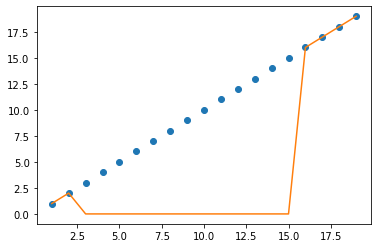

In [ ]:
x_in = np.arange(1,20)
start = 2
end = 15
signal_ = artifcat_removal(x_in, start, end)
import matplotlib.pyplot as plt
plt.plot(x_in, x_in, 'o', x_in, signal_, '-')

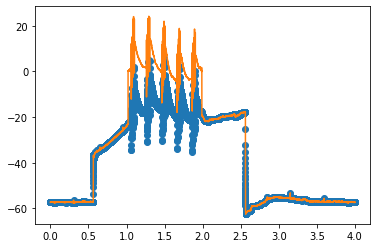

In [ ]:
x_in = df['sweep_7']
t = df['time']
start = 20000*1.02
end = 20000*1.57
signal_ = artifcat_removal(x_in, start, end)
start = 20000*1.57
end = 20000*1.99
df_new['sweep_7'] = artifcat_removal(signal_, start, end)
import matplotlib.pyplot as plt
plt.plot(t, x_in, 'o', t, df_new['sweep_7'], '-')